In [3]:
from ISLP import load_data
from ISLP.models import ModelSpec as MS 
from ISLP.torch import SimpleDataModule, SimpleModule,ErrorTracker, rec_num_workers
from ISLP.torch.imdb import load_lookup, load_tensor, load_sparse, load_sequential

import numpy as np 
import pandas as pd

from matplotlib.pyplot import subplots 
from matplotlib.pyplot import imshow

from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso, LassoCV, Ridge
from sklearn.preprocessing import StandardScaler 
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

import torch
from torch import nn
from torch.optim import RMSprop
from torch.utils.data import TensorDataset, DataLoader

from torchmetrics import (MeanAbsoluteError , R2Score, Accuracy)

from torchinfo import summary

from torchvision.io import read_image
from torchvision.datasets import MNIST, CIFAR100 
from torchvision.models import resnet50,ResNet50_Weights
from torchvision.transforms import Resize, Normalize , CenterCrop , ToTensor

from pytorch_lightning import Trainer, LightningDataModule, LightningModule
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.utilities.seed import seed_everything
from pytorch_lightning.utilities.distributed import rank_zero_only

import json 
from glob import glob 


In [2]:
from warnings import filterwarnings
filterwarnings("ignore")

In [3]:
seed_everything(0, workers=True) 
torch.use_deterministic_algorithms(True, warn_only=True)

Global seed set to 0


### 10.9.1

In [318]:
hitters = load_data("Hitters").dropna()
hitters.head()
y = hitters.pop("Salary")

np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(hitters, y)



In [319]:
categorical_cols = [
    col for col, dtype in 
    zip(X_train.columns, X_train.dtypes) if isinstance(dtype, pd.CategoricalDtype)
]

one_hot_encoder_transformer = ColumnTransformer(
    [("ohe", OneHotEncoder(sparse_output=False, drop="first"), categorical_cols)],
    remainder = "passthrough", verbose_feature_names_out = False
)
lasso_pipeline = Pipeline(
    [
        ("one hot encoding", one_hot_encoder_transformer), 
        ("standard scaler", StandardScaler()),
        ("model", LassoCV())
    ]
)

ols_pipeline = Pipeline(
    [
        ("one hot encoding", one_hot_encoder_transformer),
        ("model", LinearRegression())
    ]
)

ridge_pipeline = Pipeline(
    [
        ("one hot encoding", one_hot_encoder_transformer), 
        ("standard scaler", StandardScaler()),
        ("model", Ridge())
    ]
)

lambdas = 10 ** np.linspace(8, -2, 100) / y_train.std()
param_grid = {"model__alpha": lambdas}

grid = GridSearchCV(
    ridge_pipeline,
    param_grid,
    cv=5, 
    scoring="neg_mean_squared_error"
)


lasso_pipeline.fit(X_train, y_train)
ols_pipeline.fit(X_train, y_train)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('one hot encoding',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('ohe',
                                                                         OneHotEncoder(drop='first',
                                                                                       sparse_output=False),
                                                                         ['League',
                                                                          'Division',
                                                                          'NewLeague'])],
                                                          verbose_feature_names_out=False)),
                                       ('standard scaler', StandardScaler()),
                                       ('model', Ridge())]),
             param_grid={'model__alpha': array([2.25481864e+05, 1....
       4.74617710e-03, 3.76126418e-03, 2.98073754e-03, 2.36218352e-03,
       1.87199005e-03, 1.48352010e-03, 1.17566431e-03, 9.31693857e-04,
       7.38351448e-04, 5.85130896e-04, 4.63706228e-04, 3.67479256e-04,
       2.91221026e-04, 2.30787682e-04, 1.82895291e-04, 1.44941391e-04,
       1.14863573e-04, 9.10274176e-05, 7.21376717e-05, 5.71678711e-05,
       4.53045602e-05, 3.59030892e-05, 2.84525842e-05, 2.25481864e-05])},
             scoring='neg_mean_squared_error')

In [321]:
preds_lasso = lasso_pipeline.predict(X_test)
preds_ols = ols_pipeline.predict(X_test)
preds_ridge = grid.predict(X_test)

print(np.mean((preds_lasso - y_test) ** 2))
print(np.mean((preds_ols - y_test) ** 2))
print(np.mean((preds_ridge - y_test) ** 2))

131657.12205818866
134102.78093370935
128750.19579951474


In [322]:
class HittersModel(nn.Module):
    def __init__(self, input_size): 
        super(HittersModel, self).__init__() 
        self.flatten = nn.Flatten() 
        self.sequential = nn.Sequential(
            nn.Linear(input_size, 50), nn.ReLU(), nn.Dropout(0.4), nn.Linear(50, 1)
        )
    def forward(self, x):
        x = self.flatten(x)
        return torch.flatten(self.sequential(x))

In [323]:
X_train_for_nn = lasso_pipeline[:2].transform(X_train)
X_test_for_nn = lasso_pipeline[:2].transform(X_test)

X_train_for_nn_torch = torch.tensor(X_train_for_nn.astype(np.float32))
X_test_for_nn_torch = torch.tensor(X_test_for_nn.astype(np.float32))

y_train_for_nn_torch = torch.tensor(y_train.astype(np.float32).values)
y_test_for_nn_torch = torch.tensor(y_test.astype(np.float32).values)

hitters_train = TensorDataset(X_train_for_nn_torch, y_train_for_nn_torch)
hitters_test = TensorDataset(X_test_for_nn_torch, y_test_for_nn_torch)

In [324]:
hitters_model = HittersModel(X_train_for_nn.shape[1])

In [325]:
summary(hitters_model, X_train_for_nn.shape, col_names = ["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
HittersModel                             [197, 19]                 [197]                     --
├─Flatten: 1-1                           [197, 19]                 [197, 19]                 --
├─Sequential: 1-2                        [197, 19]                 [197, 1]                  --
│    └─Linear: 2-1                       [197, 19]                 [197, 50]                 1,000
│    └─ReLU: 2-2                         [197, 50]                 [197, 50]                 --
│    └─Dropout: 2-3                      [197, 50]                 [197, 50]                 --
│    └─Linear: 2-4                       [197, 50]                 [197, 1]                  51
Total params: 1,051
Trainable params: 1,051
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.21
Input size (MB): 0.02
Forward/backward pass size (MB): 0.08
Params size (MB): 0.00
Estimated Total Size (MB): 0.10

In [326]:
hitters_dm = SimpleDataModule(hitters_train, hitters_test, batch_size=32, num_workers=4, validation=hitters_test)

In [328]:
hitters_module = SimpleModule.regression(hitters_model, metrics={'mae': MeanAbsoluteError()})

In [329]:
hitters_logger = CSVLogger('logs', name='hitters')

In [330]:
hitters_trainer = Trainer(
    deterministic=True, max_epochs=50,
    log_every_n_steps=5, logger=hitters_logger, callbacks=[ErrorTracker()]
)
hitters_trainer.fit(hitters_module, datamodule=hitters_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type         | Params
---------------------------------------
0 | model | HittersModel | 1.1 K 
1 | loss  | MSELoss      | 0     
---------------------------------------
1.1 K     Trainable params
0         Non-trainable params
1.1 K     Total params
0.004     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [331]:
hitters_trainer.test(hitters_module, datamodule=hitters_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss               122066.375
        test_mae            269.44940185546875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 122066.375, 'test_mae': 269.44940185546875}]

In [332]:
hitters_results = pd.read_csv(hitters_logger.experiment.metrics_file_path)

In [333]:
hitters_results

,train_mae_step,epoch,step,valid_loss,valid_mae,train_loss,train_mae_epoch,test_loss,test_mae
0,518.809753,0,4,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,0,6,458651.0000,503.340973,NaN,NaN,NaN,NaN
2,NaN,0,6,NaN,NaN,461959.0625,520.668884,NaN,NaN
3,515.357849,1,9,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,1,13,376800.3125,445.519348,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
166,209.845535,49,344,NaN,NaN,NaN,NaN,NaN,NaN
167,258.454987,49,349,NaN,NaN,NaN,NaN,NaN,NaN
168,NaN,49,349,122066.3750,269.449402,NaN,NaN,NaN,NaN
169,NaN,49,349,NaN,NaN,114444.0625,245.870026,NaN,NaN


In [334]:
hitters_model.eval()

HittersModel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (sequential): Sequential(
    (0): Linear(in_features=19, out_features=50, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.4, inplace=False)
    (3): Linear(in_features=50, out_features=1, bias=True)
  )
)

In [335]:
preds = hitters_model(X_test_for_nn_torch)
torch.abs(y_test_for_nn_torch - preds).mean()

tensor(269.4494, grad_fn=<MeanBackward0>)

### 10.9.2

In [337]:
(mnist_train, mnist_test) = [
    MNIST(root='data', train=train, download=True, transform=ToTensor())
    for train in [True, False]
]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9912422/9912422 [00:00<00:00, 41724040.21it/s]


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 28881/28881 [00:00<00:00, 17241060.89it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw





100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1648877/1648877 [00:00<00:00, 2868394.53it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw




100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4542/4542 [00:00<00:00, 6612470.94it/s]


Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



In [344]:
mnist_test

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [340]:
mnist_dm = SimpleDataModule(mnist_train, mnist_test, validation=0.2, num_workers=4 , batch_size =256)

In [341]:
class MNISTModel(nn.Module): 
    def __init__(self):
        super(MNISTModel, self).__init__() 
        self.layer1 = nn.Sequential(nn.Flatten(), nn.Linear(28*28, 256), nn.ReLU(), nn.Dropout(0.4))
        self.layer2 = nn.Sequential(nn.Linear(256, 128), nn.ReLU(), nn.Dropout(0.3))
        self._forward = nn.Sequential(self.layer1, self.layer2, nn.Linear(128, 10)) 

    def forward(self, x):
        return self._forward(x)

In [345]:
mnist_model = MNISTModel()

In [347]:
for idx, (X_ ,Y_) in enumerate(mnist_dm.train_dataloader()): 
    print('X: ', X_.shape)
    print('Y: ', Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])
X:  torch.Size([256, 1, 28, 28])
Y:  torch.Size([256])


In [348]:
summary(mnist_model, input_data=X_, col_names=['input_size', 'output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
MNISTModel                               [256, 1, 28, 28]          [256, 10]                 --
├─Sequential: 1-1                        [256, 1, 28, 28]          [256, 10]                 --
│    └─Sequential: 2-1                   [256, 1, 28, 28]          [256, 256]                --
│    │    └─Flatten: 3-1                 [256, 1, 28, 28]          [256, 784]                --
│    │    └─Linear: 3-2                  [256, 784]                [256, 256]                200,960
│    │    └─ReLU: 3-3                    [256, 256]                [256, 256]                --
│    │    └─Dropout: 3-4                 [256, 256]                [256, 256]                --
│    └─Sequential: 2-2                   [256, 256]                [256, 128]                --
│    │    └─Linear: 3-5                  [256, 256]                [256, 128]                32,896
│    │    └─ReLU: 3-6     

In [4]:
class SimpleModule(LightningModule):

    """
    A simple `pytorch_lightning` module for regression problems.
    """

    def __init__(self,
                 model,
                 loss,
                 optimizer=None,
                 metrics={},
                 on_epoch=True,
                 pre_process_y_for_metrics=lambda y: y):

        super(SimpleModule, self).__init__()

        self.model = model
        self.loss = loss or nn.MSELoss()
        optimizer = optimizer or RMSprop(model.parameters())
        self._optimizer = optimizer
        self.metrics = metrics
        self.on_epoch = on_epoch
        self.pre_process_y_for_metrics = pre_process_y_for_metrics
        
    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        preds = self.forward(x)
        loss = self.loss(preds, y)
        self.log("train_loss",
                 loss,
                 on_epoch=self.on_epoch,
                 on_step=False)

        y_ = self.pre_process_y_for_metrics(y)
        for _metric in self.metrics.keys():
            self.log(f"train_{_metric}",
                     self.metrics[_metric](preds, y_),
                     on_epoch=self.on_epoch)
        return loss

    def test_step(self, batch, batch_idx):
        x, y = batch

    @rank_zero_only
    def validation_step(self, batch, batch_idx):
        x, y = batch

    def predict_step(self, batch, batch_idx):
        x, y = batch
        return y, self.forward(x)

    def configure_optimizers(self):
        return self._optimizer

    @staticmethod
    def regression(model,
                   **kwargs):
        loss = nn.MSELoss()
        return SimpleModule(model,
                            loss,
                            **kwargs)

    @staticmethod
    def binary_classification(model,
                              metrics={},
                              device=None,
                              **kwargs):
        loss = nn.BCEWithLogitsLoss()
        if 'accuracy' not in metrics:
            metrics['accuracy'] = Accuracy("binary")
        if device is not None:
            for key, metric in metrics:
                metrics[key] = metric.to(device)
        return SimpleModule(model,
                            loss,
                            metrics=metrics,
                            pre_process_y_for_metrics = lambda x: x.int(),
                            **kwargs)

    @staticmethod
    def classification(model,
                       metrics={},
                       device=None,
                       **kwargs):
        loss = nn.CrossEntropyLoss()
        if 'accuracy' not in metrics:
            metrics['accuracy'] = Accuracy("multiclass", num_classes=100)
        if device is not None:
            for key, metric in metrics:
                metrics[key] = metric.to(device)
        return SimpleModule(model,
                            loss,
                            metrics=metrics,
                            **kwargs)

mnist_module = SimpleModule.classification(mnist_model) 
mnist_logger = CSVLogger('logs', name='MNIST')

NameError: name 'mnist_model' is not defined

In [357]:
mnist_trainer = Trainer(
    deterministic=True, max_epochs=30, logger=mnist_logger ,
    callbacks=[ErrorTracker()]
) 
mnist_trainer.fit(mnist_module, datamodule=mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: logs/MNIST

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNISTModel       | 235 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
235 K     Trainable params
0         Non-trainable params
235 K     Total params
0.941     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [358]:
mnist_trainer.test(mnist_module, datamodule=mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.9645000100135803
        test_loss           0.16413652896881104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.16413652896881104, 'test_accuracy': 0.9645000100135803}]

In [367]:
class MNIST_MLR(nn.Module):
    
    def __init__(self):
        super(MNIST_MLR, self).__init__()
        self.linear = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))
        
    def forward(self, x):
        return self.linear(x)

mlr_model = MNIST_MLR()
mlr_module = SimpleModule.classification(mlr_model)
mlr_logger = CSVLogger("logs", name="MNIST_MLR")

mlr_trainer = Trainer(deterministic=True, max_epochs=30, callbacks=[ErrorTracker()])
mlr_trainer.fit(mlr_module, mnist_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Missing logger folder: /Users/nils_carlsson/dev/r_env/isl/chapter_10_python_version/lightning_logs

  | Name  | Type             | Params
-------------------------------------------
0 | model | MNIST_MLR        | 7.9 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
7.9 K     Trainable params
0         Non-trainable params
7.9 K     Total params
0.031     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [368]:
mlr_trainer.test(mlr_module, mnist_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8942000269889832
        test_loss           0.41221821308135986
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.41221821308135986, 'test_accuracy': 0.8942000269889832}]

In [373]:
cifar_train, cifar_test =  [
    CIFAR100(root="data", train=train, download=True)
    for train in [True, False]
]

Files already downloaded and verified
Files already downloaded and verified


In [374]:
transform = ToTensor()
cifar_train_X = torch.stack([transform(x) for x in cifar_train.data])
cifar_test_X = torch.stack([transform(x) for x in cifar_test.data])

cifar_train = TensorDataset(cifar_train_X, torch.tensor(cifar_train.targets))
cifar_test = TensorDataset(cifar_test_X, torch.tensor(cifar_test.targets))




In [375]:
cifar_dm = SimpleDataModule(cifar_train, cifar_test, validation=0.2, num_workers=4, batch_size=128)

In [376]:
for idx, (X_, Y_) in enumerate(cifar_dm.train_dataloader()):
    print("X: ", X_.shape)
    print("Y: ", Y_.shape)
    if idx >= 1:
        break

X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])
X:  torch.Size([128, 3, 32, 32])
Y:  torch.Size([128])


In [384]:
class BuildingBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(BuildingBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=(3,3), padding="same")
        self.activation = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=(2,2))
        
    def forward(self, x):
        return self.pool(self.activation(self.conv(x)))
        
class CIFARModel(nn.Module):
    
    def __init__(self):
        super(CIFARModel, self).__init__()
        sizes = [(3, 32), (32, 64), (64, 128), (128, 256)]
        self.conv = nn.Sequential(*[BuildingBlock(in_, out_) for in_, out_ in sizes])
        
        self.output = nn.Sequential(nn.Dropout(0.5), nn.Linear(2 * 2 * 256, 512), nn.ReLU(), nn.Linear(512, 100))
        
    def forward(self, x):
        val = self.conv(x)
        val = torch.flatten(val, start_dim=1)
        return self.output(val)

In [385]:
cifar_model = CIFARModel()
summary(cifar_model, input_data=X_, col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
CIFARModel                               [128, 3, 32, 32]          [128, 100]                --
├─Sequential: 1-1                        [128, 3, 32, 32]          [128, 256, 2, 2]          --
│    └─BuildingBlock: 2-1                [128, 3, 32, 32]          [128, 32, 16, 16]         --
│    │    └─Conv2d: 3-1                  [128, 3, 32, 32]          [128, 32, 32, 32]         896
│    │    └─ReLU: 3-2                    [128, 32, 32, 32]         [128, 32, 32, 32]         --
│    │    └─MaxPool2d: 3-3               [128, 32, 32, 32]         [128, 32, 16, 16]         --
│    └─BuildingBlock: 2-2                [128, 32, 16, 16]         [128, 64, 8, 8]           --
│    │    └─Conv2d: 3-4                  [128, 32, 16, 16]         [128, 64, 16, 16]         18,496
│    │    └─ReLU: 3-5                    [128, 64, 16, 16]         [128, 64, 16, 16]         --
│    │    └─MaxPool2d: 3-6    

In [390]:
cifar_optimizer = RMSprop(cifar_model.parameters(), lr=0.001)
cifar_module = SimpleModule.classification(cifar_model, optimizer=cifar_optimizer)
cifar_logger = CSVLogger("logs", name="CIFAR100")

In [391]:
cifar_trainer = Trainer(deterministic=True, max_epochs=30, logger=cifar_logger, callbacks=[ErrorTracker()])
cifar_trainer.fit(cifar_module, cifar_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type             | Params
-------------------------------------------
0 | model | CIFARModel       | 964 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------
964 K     Trainable params
0         Non-trainable params
964 K     Total params
3.858     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [393]:
cifar_trainer.test(cifar_module, cifar_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.4269999861717224
        test_loss           2.2991085052490234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 2.2991085052490234, 'test_accuracy': 0.4269999861717224}]

In [394]:
rec_num_workers()

4

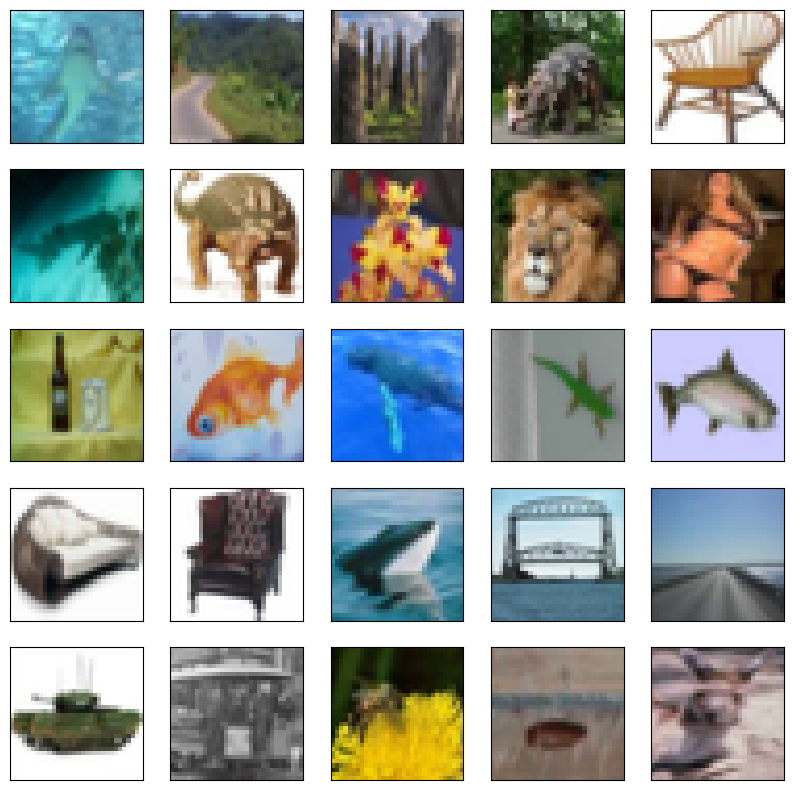

In [399]:
fig, axes = subplots(5, 5, figsize=(10, 10))
rng = np.random.default_rng(1)
indices = rng.choice(np.arange(len(cifar_train)), 25, replace=False).reshape((5, 5))
for i in range(5):
    for j in range(5):
        idx = indices[i, j]
        axes[i, j].imshow(np.transpose(cifar_train[idx][0], [1,2,0]), interpolation = None)
        axes[i, j].set_xticks([])
        axes[i, j].set_yticks([])

In [92]:
imdb_seq_train, imdb_seq_test = load_sequential(root="data/IMDB")

In [404]:
padded_sample = np.asarray(imdb_seq_train.tensors[0][0])

In [405]:
sample_review = padded_sample[padded_sample > 0][:12]

In [406]:
sample_review

array([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458,
       4468], dtype=int32)

In [407]:
lookup = load_lookup(root='data/IMDB')
' '.join(lookup[i] for i in sample_review)

Retrieving "IMDB_word_index.pkl" from "http://imdb.jtaylor.su.domains/jtaylor/data/".


"<START> this film was just brilliant casting location scenery story direction everyone's"

In [39]:
imdb_train, imdb_test = load_tensor(root="data/IMDB")
imdb_dm = SimpleDataModule(imdb_train, imdb_test, validation=2000, batch_size=512)


In [40]:
class IMDBModel(nn.Module):
    def __init__(self, input_size):
        super(IMDBModel, self).__init__()
        self.dense1 = nn.Linear(input_size, 16)
        self.activation = nn.ReLU()
        self.dense2 = nn.Linear(16, 16)
        self.output = nn.Linear(16, 1)
        
    def forward(self, x):
        val = x 
        for _map in [self.dense1, self.activation, self.dense2, self.activation, self.output]:
            val = _map(val)
        return torch.flatten(val)

In [41]:
imdb_model = IMDBModel(imdb_test.tensors[0].size()[1])

In [42]:
summary(imdb_model, input_size=imdb_test.tensors[0].size(), col_names=["input_size", "output_size", "num_params"])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
IMDBModel                                [25000, 10003]            [25000]                   --
├─Linear: 1-1                            [25000, 10003]            [25000, 16]               160,064
├─ReLU: 1-2                              [25000, 16]               [25000, 16]               --
├─Linear: 1-3                            [25000, 16]               [25000, 16]               272
├─ReLU: 1-4                              [25000, 16]               [25000, 16]               --
├─Linear: 1-5                            [25000, 16]               [25000, 1]                17
Total params: 160,353
Trainable params: 160,353
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 4.01
Input size (MB): 1000.30
Forward/backward pass size (MB): 6.60
Params size (MB): 0.64
Estimated Total Size (MB): 1007.54

In [43]:
imdb_optimizer = RMSprop(imdb_model.parameters(), lr=0.001)
imdb_module = SimpleModule.binary_classification(imdb_model, optimizer=imdb_optimizer)

In [44]:
imdb_logger = CSVLogger("logs", name="IMDB")
imdb_trainer = Trainer(deterministic=True, max_epochs=30, logger=imdb_logger, callbacks=[ErrorTracker()])
imdb_trainer.fit(imdb_module, datamodule=imdb_dm)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type              | Params
--------------------------------------------
0 | model | IMDBModel         | 160 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
160 K     Trainable params
0         Non-trainable params
160 K     Total params
0.641     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [45]:
test_results = imdb_trainer.test(imdb_module, imdb_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy         0.8497599959373474
        test_loss           1.2460297346115112
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [6]:
(X_train, y_train), (X_valid, y_valid), (X_test, y_test) = load_sparse(validation=2000, random_state=0, root="data/IMDB")

In [7]:
X_train.shape


(23000, 10003)

In [27]:
lambda_max = np.abs(X_train.T * (y_train - y_train.mean())).max()
lambda_vals = lambda_max * np.exp(np.linspace(np.log(1), np.log(1e-4), 50))
print(lambda_vals)

[1.33524963e+03 1.10644496e+03 9.16847619e+02 7.59739153e+02
 6.29552359e+02 5.21674012e+02 4.32281400e+02 3.58206858e+02
 2.96825524e+02 2.45962325e+02 2.03814903e+02 1.68889747e+02
 1.39949268e+02 1.15967949e+02 9.60960031e+01 7.96292585e+01
 6.59842096e+01 5.46773384e+01 4.53079813e+01 3.75441312e+01
 3.11106730e+01 2.57796344e+01 2.13621077e+01 1.77015562e+01
 1.46682666e+01 1.21547531e+01 1.00719483e+01 8.34604717e+00
 6.91589167e+00 5.73080365e+00 4.74878903e+00 3.93504971e+00
 3.26075050e+00 2.70199734e+00 2.23899056e+00 1.85532335e+00
 1.53740029e+00 1.27395564e+00 1.05565413e+00 8.74760166e-01
 7.24863689e-01 6.00653057e-01 4.97726815e-01 4.12437728e-01
 3.41763543e-01 2.83199890e-01 2.34671542e-01 1.94458877e-01
 1.61136943e-01 1.33524963e-01]


In [30]:
coefs = []
intercepts = []

for lambda_ in lambda_vals:
    logit = LogisticRegression(C=1 / lambda_, penalty="l1", solver="liblinear")
    logit.fit(X_train, y_train)
    coefs.append(logit.coef_.copy())
    intercepts.append(logit.intercept_)

In [31]:
coefs = np.squeeze(coefs)

In [32]:
intercepts = np.squeeze(intercepts)

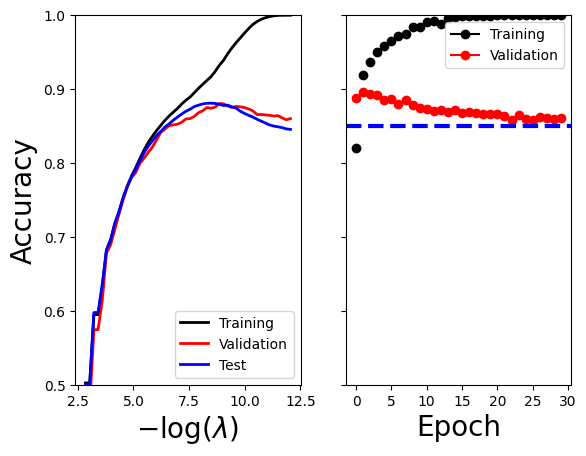

In [51]:
fig, axes = subplots(1, 2, sharey=True)

for (X_, y_), data_, color in zip([(X_train, y_train), (X_valid, y_valid), (X_test, y_test)], ["Training", "Validation", "Test"], ["black", "red", "blue"]):
    linpred = X_ * coefs.T + intercepts
    label_ = np.array(linpred > 0)
    accuracy_ = np.array([np.mean(y_ == l) for l in label_.T])
    axes[0].plot(-np.log(lambda_vals / X_train.shape[0]), accuracy_, color=color, markersize=13, linewidth=2, label=data_)
    axes[0].legend()
    axes[0].set_xlabel(r'$-\log(\lambda)$', fontsize=20)
    axes[0].set_ylabel('Accuracy', fontsize=20)
    
def summary_plot(results, ax, col="loss", valid_legend="Validation", training_legend="Training", ylabel="Loss", fontsize=20):
    for (column, color, label) in zip([f"train_{col}_epoch", f"valid_{col}"], ["black", "red"], [training_legend, valid_legend]):
        results.plot(x="epoch", y=column, label=label, marker="o", color=color, ax=ax)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(ylabel)
    return ax

imdb_results = pd.read_csv(imdb_logger.experiment.metrics_file_path)
summary_plot(imdb_results, axes[1], col='accuracy', ylabel='Accuracy')
axes[1].set_xticks(np.linspace(0, 30, 7).astype(int))
axes[1].set_ylabel('Accuracy', fontsize=20)
axes[1].set_xlabel('Epoch', fontsize=20)
axes[1].set_ylim([0.5, 1])
axes[1].axhline(test_results[0]['test_accuracy'], color='blue', linestyle='--', linewidth=3)

In [50]:
imdb_results.head(10)

,valid_loss,valid_accuracy,epoch,step,train_loss,train_accuracy_epoch,train_accuracy_step,test_loss,test_accuracy
0,0.311834,0.8885,0,44,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,0,44,0.441457,0.819826,NaN,NaN,NaN
2,NaN,NaN,1,49,NaN,NaN,0.912109,NaN,NaN
3,0.275225,0.8965,1,89,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,1,89,0.233599,0.918348,NaN,NaN,NaN
5,NaN,NaN,2,99,NaN,NaN,0.933594,NaN,NaN
6,0.278891,0.8930,2,134,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,2,134,0.178167,0.937000,NaN,NaN,NaN
8,NaN,NaN,3,149,NaN,NaN,0.947266,NaN,NaN
9,0.289764,0.8915,3,179,NaN,NaN,NaN,NaN,NaN


In [54]:
resize = Resize((232, 232))
crop = CenterCrop(224)
normalize = Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

In [60]:
imgfiles = sorted([f for f in glob('book_images/*')])

In [62]:
imgs = torch.stack([torch.div(crop(resize(read_image(f))), 255) for f in imgfiles])

In [64]:
imgs

tensor([[[[0.4471, 0.4549, 0.4549,  ..., 0.4667, 0.4549, 0.4549],
          [0.4392, 0.4431, 0.4471,  ..., 0.4784, 0.4784, 0.4667],
          [0.4588, 0.4314, 0.4784,  ..., 0.4588, 0.4588, 0.4667],
          ...,
          [0.4118, 0.4078, 0.4078,  ..., 0.4588, 0.4706, 0.4431],
          [0.3843, 0.3961, 0.3529,  ..., 0.4902, 0.4824, 0.4471],
          [0.3804, 0.3843, 0.3725,  ..., 0.4000, 0.4000, 0.3922]],

         [[0.5451, 0.5451, 0.5569,  ..., 0.5686, 0.5608, 0.5569],
          [0.5412, 0.5412, 0.5490,  ..., 0.5608, 0.5608, 0.5608],
          [0.5608, 0.5529, 0.5804,  ..., 0.5765, 0.5608, 0.5529],
          ...,
          [0.4980, 0.4902, 0.5098,  ..., 0.5608, 0.5765, 0.5490],
          [0.4902, 0.4863, 0.4510,  ..., 0.5765, 0.5686, 0.5569],
          [0.4941, 0.4784, 0.4627,  ..., 0.4980, 0.4941, 0.4980]],

         [[0.6510, 0.6471, 0.6471,  ..., 0.6667, 0.6549, 0.6471],
          [0.6392, 0.6392, 0.6431,  ..., 0.6667, 0.6667, 0.6549],
          [0.6588, 0.6353, 0.6784,  ..., 0

In [65]:
imgs = normalize(imgs)

In [66]:
imgs.size()

torch.Size([6, 3, 224, 224])

In [67]:
resnet_model = resnet50(weights=ResNet50_Weights.DEFAULT)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /Users/nils_carlsson/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 97.8M/97.8M [00:02<00:00, 47.3MB/s]


In [68]:
summary(
    resnet_model ,
    input_data=imgs, 
    col_names=['input_size', 'output_size', 'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
ResNet                                   [6, 3, 224, 224]          [6, 1000]                 --
├─Conv2d: 1-1                            [6, 3, 224, 224]          [6, 64, 112, 112]         9,408
├─BatchNorm2d: 1-2                       [6, 64, 112, 112]         [6, 64, 112, 112]         128
├─ReLU: 1-3                              [6, 64, 112, 112]         [6, 64, 112, 112]         --
├─MaxPool2d: 1-4                         [6, 64, 112, 112]         [6, 64, 56, 56]           --
├─Sequential: 1-5                        [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    └─Bottleneck: 2-1                   [6, 64, 56, 56]           [6, 256, 56, 56]          --
│    │    └─Conv2d: 3-1                  [6, 64, 56, 56]           [6, 64, 56, 56]           4,096
│    │    └─BatchNorm2d: 3-2             [6, 64, 56, 56]           [6, 64, 56, 56]           128
│    │    └─ReLU: 3-3      

In [69]:
resnet_model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [70]:
img_preds = resnet_model(imgs)

In [71]:
img_probs = np.exp(np.asarray(img_preds.detach()))

In [82]:
img_probs /= img_probs.sum(1)[:,None]

In [83]:
labs = json.load(open('imagenet_class_index.json'))

In [84]:
labs

{'0': ['n01440764', 'tench'],
 '1': ['n01443537', 'goldfish'],
 '2': ['n01484850', 'great_white_shark'],
 '3': ['n01491361', 'tiger_shark'],
 '4': ['n01494475', 'hammerhead'],
 '5': ['n01496331', 'electric_ray'],
 '6': ['n01498041', 'stingray'],
 '7': ['n01514668', 'cock'],
 '8': ['n01514859', 'hen'],
 '9': ['n01518878', 'ostrich'],
 '10': ['n01530575', 'brambling'],
 '11': ['n01531178', 'goldfinch'],
 '12': ['n01532829', 'house_finch'],
 '13': ['n01534433', 'junco'],
 '14': ['n01537544', 'indigo_bunting'],
 '15': ['n01558993', 'robin'],
 '16': ['n01560419', 'bulbul'],
 '17': ['n01580077', 'jay'],
 '18': ['n01582220', 'magpie'],
 '19': ['n01592084', 'chickadee'],
 '20': ['n01601694', 'water_ouzel'],
 '21': ['n01608432', 'kite'],
 '22': ['n01614925', 'bald_eagle'],
 '23': ['n01616318', 'vulture'],
 '24': ['n01622779', 'great_grey_owl'],
 '25': ['n01629819', 'European_fire_salamander'],
 '26': ['n01630670', 'common_newt'],
 '27': ['n01631663', 'eft'],
 '28': ['n01632458', 'spotted_salama

In [86]:
class_labels = pd.DataFrame([(int(k), v[1]) for k, v in
labs.items()],
columns=['idx', 'label']) 
class_labels = class_labels.set_index('idx')
class_labels = class_labels.sort_index()
class_labels

,label
idx,
0,tench
1,goldfish
2,great_white_shark
3,tiger_shark
4,hammerhead
...,...
995,earthstar
996,hen-of-the-woods
997,bolete


In [88]:
for i, imgfile in enumerate(imgfiles):
    img_df = class_labels.copy()
    img_df['prob'] = img_probs[i]
    img_df = img_df.sort_values(by='prob', ascending=False)[:3] 
    print(f'Image: {imgfile}') 
    print(img_df.reset_index().drop(columns=['idx']))

Image: book_images/flamingo.jpg
            label      prob
0        flamingo  0.591761
1       spoonbill  0.012386
2  American_egret  0.002105
Image: book_images/hawk.jpg
            label      prob
0  great_grey_owl  0.287959
1            kite  0.039478
2        fountain  0.029384
Image: book_images/hawk_cropped.jpeg
    label      prob
0    kite  0.301841
1     jay  0.121658
2  magpie  0.015511
Image: book_images/huey.jpg
             label      prob
0            Lhasa  0.151153
1         Shih-Tzu  0.129804
2  Tibetan_terrier  0.102400
Image: book_images/kitty.jpg
       label      prob
0      tabby  0.173627
1  tiger_cat  0.110414
2    doormat  0.093447
Image: book_images/weaver.jpg
       label      prob
0    jacamar  0.287283
1  bee_eater  0.046768
2     bulbul  0.037507


In [89]:
class LSTMModel(nn.Module):
    def __init__(self, input_size):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(input_size, 32)
        self.lstm = nn.LSTM(input_size=32, hidden_size=32, batch_first=True)
        self.dense = nn.Linear(32, 1)
        
    def forward(self, x):
        val, (h_n, c_n) = self.lstm(self.embedding(x))
        
        return torch.flatten(self.dense(val[:, -1]))

In [90]:
lstm_model = LSTMModel(X_test.shape[-1])

In [93]:
summary(lstm_model, input_data=imdb_seq_train.tensors[0][:10], col_names=['input_size','output_size', 'num_params'])

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
LSTMModel                                [10, 500]                 [10]                      --
├─Embedding: 1-1                         [10, 500]                 [10, 500, 32]             320,096
├─LSTM: 1-2                              [10, 500, 32]             [10, 500, 32]             8,448
├─Linear: 1-3                            [10, 32]                  [10, 1]                   33
Total params: 328,577
Trainable params: 328,577
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 45.44
Input size (MB): 50.00
Forward/backward pass size (MB): 2.56
Params size (MB): 1.31
Estimated Total Size (MB): 53.87

In [95]:
lstm_module = SimpleModule.binary_classification(lstm_model) 
lstm_logger = CSVLogger('logs', name='IMDB_LSTM')

In [96]:
lstm_trainer = Trainer(
    deterministic=True, max_epochs=20,
    logger=lstm_logger ,
    callbacks=[ErrorTracker()]
)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [100]:
imdb_seq_dm = SimpleDataModule(imdb_seq_train, imdb_seq_test ,
validation=2000,
batch_size=300,
num_workers=4)
lstm_trainer.fit(
    lstm_module,
    datamodule=imdb_seq_dm
)

Missing logger folder: logs/IMDB_LSTM

  | Name  | Type              | Params
--------------------------------------------
0 | model | LSTMModel         | 328 K 
1 | loss  | BCEWithLogitsLoss | 0     
--------------------------------------------
328 K     Trainable params
0         Non-trainable params
328 K     Total params
1.314     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [101]:
lstm_trainer.test(lstm_module, datamodule=imdb_seq_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
      test_accuracy          0.837119996547699
        test_loss           0.8441449999809265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.8441449999809265, 'test_accuracy': 0.837119996547699}]

In [4]:
NYSE = load_data('NYSE')

In [5]:
NYSE

,day_of_week,DJ_return,log_volume,log_volatility,train
date,,,,,
1962-12-03,mon,-0.004461,0.032573,-13.127403,True
1962-12-04,tues,0.007813,0.346202,-11.749305,True
1962-12-05,wed,0.003845,0.525306,-11.665609,True
1962-12-06,thur,-0.003462,0.210182,-11.626772,True
1962-12-07,fri,0.000568,0.044187,-11.728130,True
...,...,...,...,...,...
1986-12-24,wed,0.006514,-0.236104,-9.807366,False
1986-12-26,fri,0.001825,-1.322425,-9.906025,False
1986-12-29,mon,-0.009515,-0.371237,-9.827660,False


In [6]:
cols = ['DJ_return', 'log_volume', 'log_volatility']
X = pd.DataFrame(
    StandardScaler(
        with_mean=True,
        with_std=True
    ).fit_transform(NYSE[cols]), 
    columns=NYSE[cols].columns,
    index=NYSE.index
)

In [7]:
X.head()

,DJ_return,log_volume,log_volatility
date,,,
1962-12-03,-0.549823,0.175075,-4.357078
1962-12-04,0.905200,1.517291,-2.529058
1962-12-05,0.434813,2.283789,-2.418037
1962-12-06,-0.431397,0.935176,-2.366521
1962-12-07,0.046340,0.224779,-2.500970


In [8]:
for lag in range(1, 6):
    for col in cols: 
        newcol = np.zeros(X.shape[0]) * np.nan
        newcol[lag:] = X[col].values[:-lag]
        X.insert(len(X.columns), "{field}_{lag}".format(field=col, lag=lag),newcol)
X["train"] = NYSE['train']
X = X.dropna()

In [9]:
y, train_idx = X.log_volume, X.train
X = X.drop(columns=["train"] + cols)

In [10]:
linear_model = LinearRegression()
linear_model.fit(X[train_idx], y[train_idx])
linear_model.score(X[~train_idx], y[~train_idx])

0.4128912938562521

In [11]:
linear_model.feature_names_in_

array(['DJ_return_1', 'log_volume_1', 'log_volatility_1', 'DJ_return_2',
       'log_volume_2', 'log_volatility_2', 'DJ_return_3', 'log_volume_3',
       'log_volatility_3', 'DJ_return_4', 'log_volume_4',
       'log_volatility_4', 'DJ_return_5', 'log_volume_5',
       'log_volatility_5'], dtype=object)

In [12]:
X_day = X.copy()

In [13]:
transformer = OneHotEncoder(sparse_output=False, drop="first")
dummy_vars = transformer.fit_transform(NYSE[["day_of_week"]])

In [14]:
dummy_vars

array([[1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       ...,
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.]])

In [15]:
categorical_names = transformer.categories_[0][1:]
cat_df = pd.DataFrame(dummy_vars, columns=categorical_names)
cat_df.index = NYSE.index


In [17]:
full_df = pd.merge(X, cat_df, left_index=True, right_index=True)

In [18]:
full_df.shape

(6046, 19)

In [19]:
day_model = LinearRegression()
day_model.fit(full_df[train_idx], y[train_idx])

LinearRegression()

In [20]:
day_model.score(full_df[~train_idx], y[~train_idx])

0.4595563133053274

In [176]:
ordered_cols = []
for lag in range(5, 0, -1):
    for col in cols: 
        ordered_cols.append("{field}_{lag}".format(field=col, lag=lag))
X.reindex(columns=ordered_cols)

,DJ_return_5,log_volume_5,log_volatility_5,DJ_return_4,log_volume_4,log_volatility_4,DJ_return_3,log_volume_3,log_volatility_3,DJ_return_2,log_volume_2,log_volatility_2,DJ_return_1,log_volume_1,log_volatility_1
date,,,,,,,,,,,,,,,
1962-12-10,-0.549823,0.175075,-4.357078,0.905200,1.517291,-2.529058,0.434813,2.283789,-2.418037,-0.431397,0.935176,-2.366521,0.046340,0.224779,-2.500970
1962-12-11,0.905200,1.517291,-2.529058,0.434813,2.283789,-2.418037,-0.431397,0.935176,-2.366521,0.046340,0.224779,-2.500970,-1.304126,0.605918,-1.366028
1962-12-12,0.434813,2.283789,-2.418037,-0.431397,0.935176,-2.366521,0.046340,0.224779,-2.500970,-1.304126,0.605918,-1.366028,-0.006294,-0.013661,-1.505667
1962-12-13,-0.431397,0.935176,-2.366521,0.046340,0.224779,-2.500970,-1.304126,0.605918,-1.366028,-0.006294,-0.013661,-1.505667,0.377081,0.042552,-1.551515
1962-12-14,0.046340,0.224779,-2.500970,-1.304126,0.605918,-1.366028,-0.006294,-0.013661,-1.505667,0.377081,0.042552,-1.551515,-0.411718,-0.419836,-1.597607
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1986-12-24,-1.118959,-0.149916,0.375045,-0.360744,0.143003,0.252350,0.968266,4.258402,0.263406,-0.185178,1.602669,0.128004,-0.750046,1.964846,0.080250
1986-12-26,-0.360744,0.143003,0.252350,0.968266,4.258402,0.263406,-0.185178,1.602669,0.128004,-0.750046,1.964846,0.080250,0.751210,-0.974763,0.046886
1986-12-29,0.968266,4.258402,0.263406,-0.185178,1.602669,0.128004,-0.750046,1.964846,0.080250,0.751210,-0.974763,0.046886,0.195352,-5.623814,-0.083983


In [21]:
X_rnn = X.to_numpy().reshape((-1, 5, 3))

In [22]:
X_rnn.shape

(6046, 5, 3)

In [23]:
class NYSEModel(nn.Module):
    def __init__(self):
        super(NYSEModel, self).__init__()
        self.rnn = nn.RNN(3, 12, batch_first=True)
        self.dense = nn.Linear(12, 1)
        self.dropout = nn.Dropout(0.1)
    def forward(self, x):
        val, h_n = self.rnn(x)
        val = self.dense(self.dropout(val[:, -1]))
        return torch.flatten(val)
nyse_model = NYSEModel()

In [24]:
datasets = []
for mask in [train_idx, ~train_idx]:
    X_rnn_t = torch.tensor(X_rnn[mask].astype(np.float32))
    y_t = torch.tensor(y[mask].astype(np.float32))
    datasets.append(TensorDataset(X_rnn_t, y_t))
nyse_train, nyse_test = datasets

In [25]:
summary(
    nyse_model, input_data=X_rnn_t,
    col_names=['input_size', 'output_size', 'num_params']
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #
NYSEModel                                [1770, 5, 3]              [1770]                    --
├─RNN: 1-1                               [1770, 5, 3]              [1770, 5, 12]             204
├─Dropout: 1-2                           [1770, 12]                [1770, 12]                --
├─Linear: 1-3                            [1770, 12]                [1770, 1]                 13
Total params: 217
Trainable params: 217
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 1.83
Input size (MB): 0.11
Forward/backward pass size (MB): 0.86
Params size (MB): 0.00
Estimated Total Size (MB): 0.97

In [26]:
nyse_dm = SimpleDataModule(nyse_train, nyse_test, num_workers=4, validation=nyse_test, batch_size=64)

In [27]:
nyse_optimizer = RMSprop(nyse_model.parameters(), lr=0.001)
nyse_module = SimpleModule.regression(nyse_model, optimizer=nyse_optimizer ,
metrics={'r2':R2Score()})

In [28]:
nyse_trainer = Trainer(deterministic=True, max_epochs=15,
callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [29]:
nyse_trainer.fit(nyse_module,
datamodule=nyse_dm)


  | Name  | Type      | Params
------------------------------------
0 | model | NYSEModel | 217   
1 | loss  | MSELoss   | 0     
------------------------------------
217       Trainable params
0         Non-trainable params
217       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [1]:
print(1)

1


In [30]:
nyse_trainer.test(nyse_module,
datamodule=nyse_dm)



Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.656101644039154
         test_r2            0.37732750177383423
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.656101644039154, 'test_r2': 0.37732750177383423}]

In [33]:
datasets = []
for mask in [train_idx, ~train_idx]:
    X_day_t = torch.tensor(np.asarray(full_df[mask]).astype(np.float32))
    y_t = torch.tensor(np.asarray(y[mask]).astype(np.float32))
    datasets.append(TensorDataset(X_day_t, y_t))
day_train, day_test = datasets

In [35]:
day_dm = SimpleDataModule(day_train, day_test, num_workers=4, validation=day_test, batch_size=64)

In [41]:
class NonLinearARModel(nn.Module):
    def __init__(self):
        super(NonLinearARModel, self).__init__()
        self._forward = nn.Sequential(nn.Flatten(), nn.Linear(19, 32), nn.ReLU(), nn.Dropout(0.5), nn.Linear(32, 1))
        
    def forward(self, x):
        return torch.flatten(self._forward(x))

In [43]:
nl_model = NonLinearARModel()
nl_optimizer = RMSprop(nl_model.parameters(),
lr=0.001)
nl_module = SimpleModule.regression(nl_model,
optimizer=nl_optimizer , metrics={'r2':R2Score()})

In [44]:
nl_trainer = Trainer(deterministic=True, max_epochs=20,
callbacks=[ErrorTracker()])

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [45]:
nl_trainer.fit(nl_module, datamodule=day_dm)



  | Name  | Type             | Params
-------------------------------------------
0 | model | NonLinearARModel | 673   
1 | loss  | MSELoss          | 0     
-------------------------------------------
673       Trainable params
0         Non-trainable params
673       Total params
0.003     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [46]:
nl_trainer.test(nl_module, datamodule=day_dm)

Testing: 0it [00:00, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Runningstage.testing metric      DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.5669869184494019
         test_r2            0.4619017243385315
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.5669869184494019, 'test_r2': 0.4619017243385315}]